In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import linear_reset
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import normal_ad

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

In [39]:
TEXT_PATH  = "text_features_qa_only.csv"
EVENT_PATH = "event_AR_CAR_mm_ff3.csv"

text = pd.read_csv(TEXT_PATH, parse_dates=["file_date"])
ev   = pd.read_csv(EVENT_PATH, parse_dates=["AnnounceDate", "datadate"])

print("text shape:", text.shape)
print("ev shape:  ", ev.shape)

text.head(3)

text shape: (2549, 30)
ev shape:   (9955, 12)


,file_name,file_date,ric_from_fname,n_words,n_chars,num_count,pct_count,money_count,sent_bert,kw_synergy,kw_accretive,kw_dilutive,kw_debt,kw_integration,kw_guidance,kw_growth,kw_risk,kw_concern,kw_uncertain,kw_delay,kw_margin,kw_cost,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
0,2003-Dec-08-Acxiom LLC-140477246411-Brief.txt,2003-12-08,NaN,5136,29354,137,0,2,0.201596,1,1,1,1,1,0,1,0,0,0,0,1,1,0.0,0.0,0.060209,0.005751,0.003290,0.000079,0.006208,0.000000
1,2003-Dec-15-MFE.N^C11-138286857648-Brief.txt,2003-12-15,MFE.N^C11,1888,10775,71,0,0,0.443032,0,0,0,0,0,1,0,0,1,0,0,1,0,0.0,0.0,0.043835,0.000000,0.000000,0.003539,0.000000,0.011314
2,2003-Dec-16-NFB.N^L06-136907498398-Brief.txt,2003-12-16,NFB.N^L06,6565,37640,251,0,18,-0.724407,0,0,0,1,0,0,1,0,0,0,0,1,1,0.0,0.0,0.040930,0.001415,0.006005,0.012583,0.000000,0.004564


In [40]:
print("Text columns:\n", text.columns.tolist())
print("\nEvent columns:\n", ev.columns.tolist())

print("\nText date range:", text["file_date"].min(), "→", text["file_date"].max())
print("Event announce date range:", ev["AnnounceDate"].min(), "→", ev["AnnounceDate"].max())
print("Unique RICs in text (non-null):", text["ric_from_fname"].dropna().nunique())
print("Unique RICs in events:", ev["RIC"].nunique())

Text columns:
 ['file_name', 'file_date', 'ric_from_fname', 'n_words', 'n_chars', 'num_count', 'pct_count', 'money_count', 'sent_bert', 'kw_synergy', 'kw_accretive', 'kw_dilutive', 'kw_debt', 'kw_integration', 'kw_guidance', 'kw_growth', 'kw_risk', 'kw_concern', 'kw_uncertain', 'kw_delay', 'kw_margin', 'kw_cost', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7']

Event columns:
 ['RIC', 'AcquirorName', 'TargetName', 'AnnounceDate', 'datadate', 'tau', 'prccd', 'ret', 'ar_mm', 'car_mm', 'ar_ff3', 'car_ff3']

Text date range: 2003-12-08 00:00:00 → 2022-12-19 00:00:00
Event announce date range: 1995-02-13 00:00:00 → 2021-12-23 00:00:00
Unique RICs in text (non-null): 1239
Unique RICs in events: 905


In [41]:
event_key = ["RIC", "AnnounceDate"]

window = ev[ev["tau"].isin([-1, 0, 1])].copy()

event_car = (
    window.groupby(event_key, as_index=False)
          .agg(
              CAR_mm_m1_p1=("ar_mm", "sum"),
              CAR_ff3_m1_p1=("ar_ff3", "sum"),
              prccd_mean_win=("prccd", "mean")
          )
)

event_car.head()

,RIC,AnnounceDate,CAR_mm_m1_p1,CAR_ff3_m1_p1,prccd_mean_win
0,A.N,2003-06-05,-0.013623,-0.029006,19.623333
1,AABA.OQ^J19,2002-11-15,0.104848,0.106737,17.303333
2,AAP.N,2005-08-10,-0.057880,-0.055828,68.016667
3,ABBV.N,2013-05-14,0.010244,0.012470,45.306667
4,ABT.N,2003-04-04,-0.001495,0.011295,39.910000


In [42]:
text2 = text.copy()

# standardize and keep only matchable rows
text2["RIC"] = text2["ric_from_fname"].astype(str).replace({"nan": np.nan})
text2 = text2.dropna(subset=["RIC", "file_date"]).copy()

print("Rows in text2 (matchable):", text2.shape[0])
text2[["file_name", "file_date", "RIC"]].head()

Rows in text2 (matchable): 2418


,file_name,file_date,RIC
1,2003-Dec-15-MFE.N^C11-138286857648-Brief.txt,2003-12-15,MFE.N^C11
2,2003-Dec-16-NFB.N^L06-136907498398-Brief.txt,2003-12-16,NFB.N^L06
3,2003-Dec-18-CL.N-139888600104-Brief.txt,2003-12-18,CL.N
4,2003-Dec-19-MDCO.OQ^A20-139635792615-Brief.txt,2003-12-19,MDCO.OQ^A20
5,2003-Dec-19-SSP.OQ-140915381200-Brief.txt,2003-12-19,SSP.OQ


In [43]:
df = pd.merge(
    text2,
    event_car,
    on=["RIC"],
    how="inner"
)

print("Exact merge rows:", df.shape[0])
df[["file_name", "file_date", "RIC", "CAR_ff3_m1_p1"]].head()
df["year"] = df["file_date"].dt.year
df[["file_name","file_date","RIC","AnnounceDate","CAR_ff3_m1_p1"]].head()

Exact merge rows: 1828


,file_name,file_date,RIC,AnnounceDate,CAR_ff3_m1_p1
0,2003-Dec-15-MFE.N^C11-138286857648-Brief.txt,2003-12-15,MFE.N^C11,2003-01-06,0.104782
1,2003-Dec-16-NFB.N^L06-136907498398-Brief.txt,2003-12-16,NFB.N^L06,2003-01-29,0.005690
2,2003-Dec-18-CL.N-139888600104-Brief.txt,2003-12-18,CL.N,2004-12-13,0.001350
3,2003-Dec-19-MDCO.OQ^A20-139635792615-Brief.txt,2003-12-19,MDCO.OQ^A20,2008-08-05,0.039280
4,2003-Dec-19-SSP.OQ-140915381200-Brief.txt,2003-12-19,SSP.OQ,2003-12-19,-0.012806


In [44]:
df["log_words"] = np.log1p(df["n_words"])
df["log_nums"]  = np.log1p(df["num_count"])
df["log_money"] = np.log1p(df["money_count"])

topic_vars = [c for c in df.columns if c.startswith("topic_")]

df[["CAR_ff3_m1_p1", "sent_bert", "log_words", "log_nums", "log_money", "pct_count"]].describe()

,CAR_ff3_m1_p1,sent_bert,log_words,log_nums,log_money,pct_count
count,1828.000000,1785.000000,1828.000000,1828.000000,1828.000000,1828.000000
mean,0.002343,0.012585,8.204149,5.473019,1.965786,8.328775
std,0.089817,0.393755,1.368178,1.398817,0.974399,8.460585
min,-0.713001,-0.985579,0.000000,0.000000,0.000000,0.000000
25%,-0.021175,-0.271912,8.120440,4.644391,1.386294,2.000000
50%,0.001655,-0.011905,8.460411,5.298317,2.079442,6.000000
75%,0.026545,0.279005,8.733312,6.688977,2.708050,12.000000
max,0.883096,0.998808,9.780133,7.839919,4.060443,58.000000


In [59]:
w = pd.to_numeric(df["n_words"], errors="coerce").replace(0, np.nan)

df["num_per_word"] = (pd.to_numeric(df["num_count"], errors="coerce") / w).fillna(0)
df["money_per_word"] = (pd.to_numeric(df["money_count"], errors="coerce") / w).fillna(0)
df["pct_per_word"] = (pd.to_numeric(df["pct_count"], errors="coerce") / w).fillna(0)

# uncertainty index (combine related keyword indicators)
df["uncert_index"] = (
    pd.to_numeric(df["kw_risk"], errors="coerce").fillna(0)
    + pd.to_numeric(df["kw_concern"], errors="coerce").fillna(0)
    + pd.to_numeric(df["kw_uncertain"], errors="coerce").fillna(0)
    + pd.to_numeric(df["kw_delay"], errors="coerce").fillna(0)
)
df["log_uncert_index"] = np.log1p(df["uncert_index"].clip(lower=0))

# exclude timestamp/sync/id topics from main regression
topic_vars = [c for c in topic_vars if c not in ["topic_0", "topic_1", "topic_5"]]

text_vars = [
    "sent_bert",
    "log_uncert_index",
    "kw_debt", "kw_dilutive", "kw_accretive", "kw_integration",
    "kw_synergy", "kw_margin", "kw_cost", "kw_growth", "kw_guidance"
]

controls = ["log_words", "num_per_word", "money_per_word", "pct_per_word"] + topic_vars

# safety check: show missing columns
needed = text_vars + controls + ["CAR_ff3_m1_p1"]
missing = [c for c in needed if c not in df.columns]
print("Missing columns:", missing)

# if something is missing, drop it instead of crashing
text_vars = [c for c in text_vars if c in df.columns]
controls  = [c for c in controls  if c in df.columns]


Missing columns: []


In [60]:
X = df[text_vars + controls].copy()

# drop log_nums due to severe multicollinearity (VIF ~ 42); log_words already controls for document scale
if "log_nums" in X.columns:
    X = X.drop(columns=["log_nums"])

topic_cols = sorted([c for c in X.columns if c.startswith("topic_")])
if len(topic_cols) > 0:
    topic_sum = X[topic_cols].sum(axis=1)
    # If sums are (almost) constant at 1, then drop one topic to avoid collinearity
    if np.nanmax(np.abs(topic_sum - 1.0)) < 1e-6:
        base_topic = topic_cols[-1]
        X = X.drop(columns=[base_topic])
        print("Topics sum to 1 -> dropped base topic to avoid perfect multicollinearity:", base_topic)
    else:
        print("Keeping all topic columns.")

# year FE only if df has 'year'
if "year" in df.columns:
    year_dummies = pd.get_dummies(df["year"], prefix="yr", drop_first=True)
    X = X.join(year_dummies)

# add constant
X = sm.add_constant(X, has_constant="add")

# convert everything to numeric, force failures to NaN
X = X.apply(lambda s: pd.to_numeric(s, errors="coerce"))

# replace inf/-inf
X = X.replace([np.inf, -np.inf], np.nan)

# drop duplicate columns
X = X.loc[:, ~X.columns.duplicated()]

# dep var
y = pd.to_numeric(df["CAR_ff3_m1_p1"], errors="coerce").replace([np.inf, -np.inf], np.nan)

# Identify binary columns (0/1) and keep them unchanged
binary_cols = []
for c in X.columns:
    if c == "const":
        continue
    vals = X[c].dropna().unique()
    if len(vals) <= 2 and set(vals).issubset({0, 1}):
        binary_cols.append(c)

cont_cols = [c for c in X.columns if c not in (["const"] + binary_cols)]

# z-score continuous columns
X[cont_cols] = (X[cont_cols] - X[cont_cols].mean()) / X[cont_cols].std(ddof=0)


# align complete cases
mask = X.notnull().all(axis=1) & y.notnull()
X2, y2 = X.loc[mask].astype(float), y.loc[mask].astype(float)

print("Regression N:", len(y2), " | k:", X2.shape[1]) 

# run model 
model = sm.OLS(y2.to_numpy(), X2.to_numpy()).fit(cov_type="HC3") 
print(model.summary())

Keeping all topic columns.
Regression N: 1785  | k: 40
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.000
Date:                Sat, 10 Jan 2026   Prob (F-statistic):              0.470
Time:                        19:15:32   Log-Likelihood:                 1807.1
No. Observations:                1785   AIC:                            -3534.
Df Residuals:                    1745   BIC:                            -3315.
Df Model:                          39                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

In [61]:
# compute Variance Inflation Factors (VIF) to diagnose multicollinearity
X_vif = X2.drop(columns=["const"])

vif_df = pd.DataFrame({
    "variable": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
}).sort_values("VIF", ascending=False)

vif_df.head(30)

,variable,VIF
9,kw_growth,8.978763
8,kw_cost,8.464419
15,topic_2,6.659175
12,num_per_word,6.613649
6,kw_synergy,5.432156
2,kw_debt,5.190098
16,topic_3,4.737788
7,kw_margin,3.298542
10,kw_guidance,2.670502
27,yr_2011,2.632431


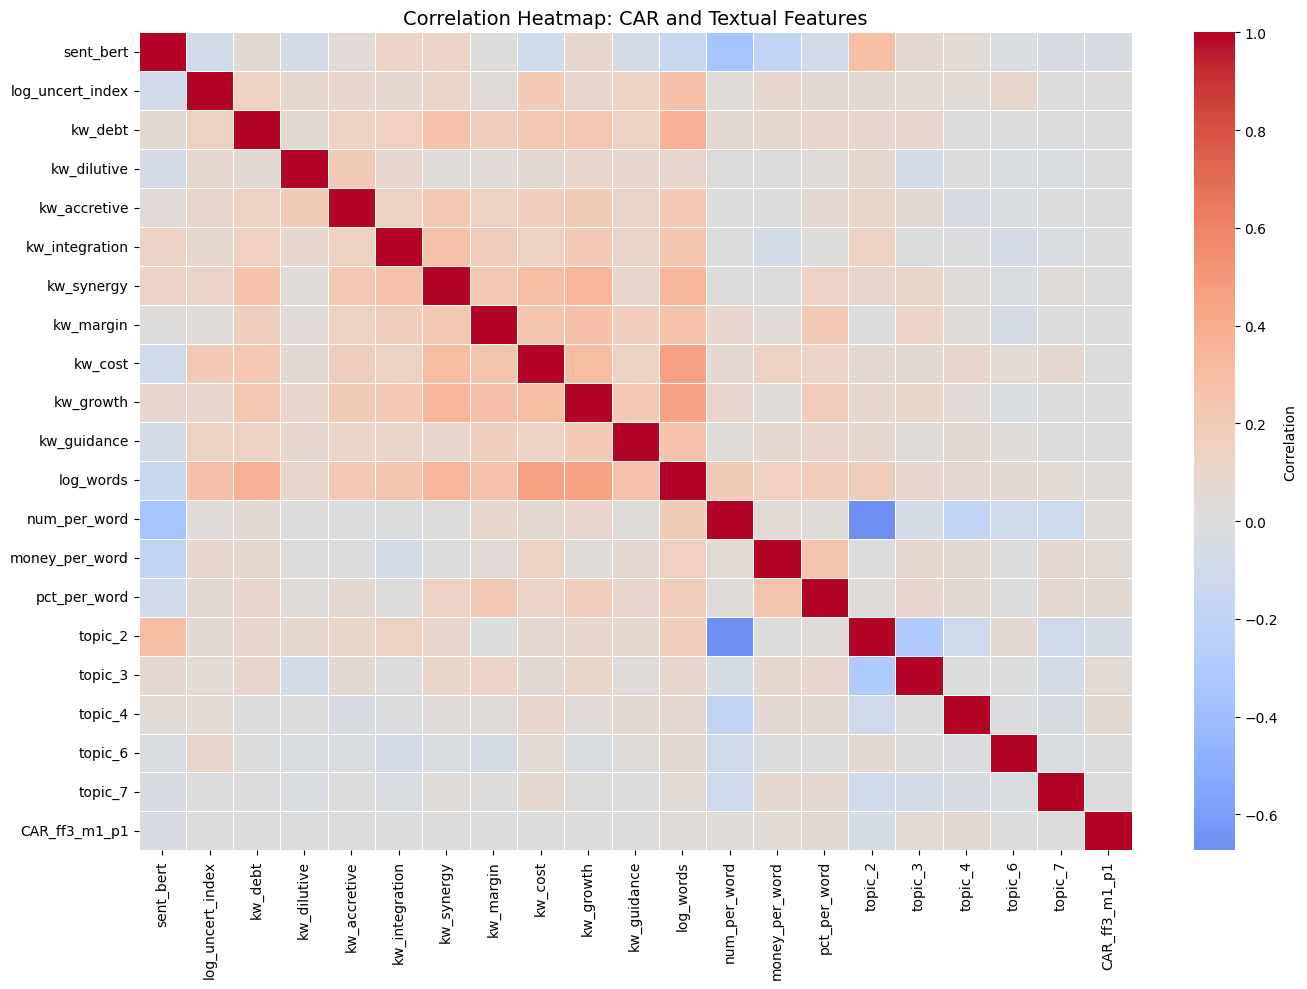

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

# compute correlation matrix
corr_df = df[needed].corr()

# plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_df,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"label": "Correlation"}
)

plt.title("Correlation Heatmap: CAR and Textual Features", fontsize=14)
plt.tight_layout()
plt.show()

### Interpreting the correlation heatmap

The heatmap shows the correlation between short-window abnormal returns (CAR −1,+1) and the different textual features, such as sentiment, keyword indicators, and topic shares. Overall, the correlations are very small and close to zero.

This means that changes in tone, the use of risk or uncertainty-related words, or differences in thematic content are not strongly linked to immediate stock price reactions around announcement dates. In other words, firms that use more positive or more cautious language do not systematically experience higher or lower abnormal returns in the short run.

This visual result is consistent with the regression analysis above and supports the idea that short-term market reactions are mainly driven by the economic substance of the event itself, rather than by how the information is worded in related news or disclosures.

# Further analysis

In [70]:
model_named = sm.OLS(y2, X2).fit(cov_type="HC3")

print(model_named.summary())

                            OLS Regression Results                            
Dep. Variable:          CAR_ff3_m1_p1   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.000
Date:                Sat, 10 Jan 2026   Prob (F-statistic):              0.470
Time:                        20:34:32   Log-Likelihood:                 1807.1
No. Observations:                1785   AIC:                            -3534.
Df Residuals:                    1745   BIC:                            -3315.
Df Model:                          39                                         
Covariance Type:                  HC3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0103      0.054  

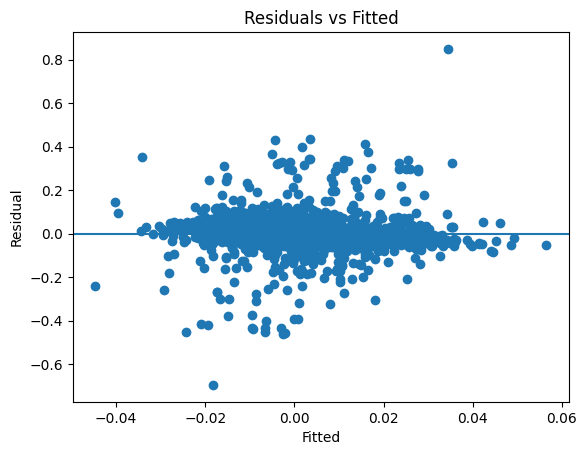

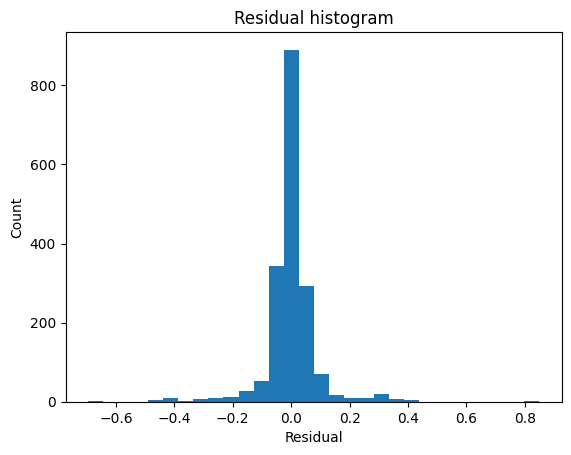

{'LM stat': np.float64(48.77980307182627),
 'LM p-value': np.float64(0.13556700764489613),
 'F stat': np.float64(1.2570891067161043),
 'F p-value': np.float64(0.1338548368937299)}

In [64]:
resid  = model.resid
fitted = model.fittedvalues

plt.figure()
plt.scatter(fitted, resid)
plt.axhline(0)
plt.title("Residuals vs Fitted")
plt.xlabel("Fitted")
plt.ylabel("Residual")
plt.show()

plt.figure()
plt.hist(resid, bins=30)
plt.title("Residual histogram")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()

bp = het_breuschpagan(resid, model.model.exog)
bp_labels = ["LM stat", "LM p-value", "F stat", "F p-value"]
dict(zip(bp_labels, bp))

In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan, het_white, linear_reset
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import normal_ad

# residuals / fitted
resid = model_named.resid
fitted = model_named.fittedvalues

# functional form / omitted nonlinearities
print("\n--- Ramsey RESET (power=2) ---")
try:
    print(linear_reset(model_named, power=2, use_f=True))
except Exception as e:
    print("RESET failed:", e)

# heteroskedasticity tests 
print("\n--- Breusch-Pagan ---")
bp = het_breuschpagan(resid, X2)
print({"LM": bp[0], "LM_p": bp[1], "F": bp[2], "F_p": bp[3]})

print("\n--- White test ---")
wt = het_white(resid, X2)
print({"LM": wt[0], "LM_p": wt[1], "F": wt[2], "F_p": wt[3]})

# normality tests 
print("\n--- Jarque-Bera ---")
jb = jarque_bera(resid)
print({"JB": jb[0], "JB_p": jb[1], "skew": jb[2], "kurtosis": jb[3]})

print("\n--- Anderson-Darling (normality) ---")
ad = normal_ad(resid)
print({"AD": ad[0], "AD_p": ad[1]})


print("\nCondition number:", float(np.linalg.cond(X2.values)))



--- Ramsey RESET (power=2) ---
<F test: F=0.0008897771517188595, p=0.9762067376416388, df_denom=1.74e+03, df_num=1>

--- Breusch-Pagan ---
{'LM': np.float64(48.77980307182627), 'LM_p': np.float64(0.13556700764489613), 'F': np.float64(1.2570891067161043), 'F_p': np.float64(0.1338548368937299)}

--- White test ---
{'LM': np.float64(637.5102582098677), 'LM_p': np.float64(0.18168839040481358), 'F': np.float64(1.0799683596392313), 'F_p': np.float64(0.13571219672549964)}

--- Jarque-Bera ---
{'JB': np.float64(15722.440607547775), 'JB_p': np.float64(0.0), 'skew': np.float64(0.06963113260283865), 'kurtosis': np.float64(17.538733282191526)}

--- Anderson-Darling (normality) ---
{'AD': np.float64(inf), 'AD_p': 0.0}

Condition number: 168.38874315903496


In [12]:
jb_stat, jb_p, skew, kurt = jarque_bera(resid)
ad_stat, ad_p = normal_ad(resid)

print({"JB_stat": jb_stat, "JB_p": jb_p, "AD_stat": ad_stat, "AD_p": ad_p, "skew": skew, "kurtosis": kurt})

reset = linear_reset(model, power=2, use_f=True)
print({"RESET_F": float(reset.fvalue), "RESET_p": float(reset.pvalue)})

{'JB_stat': np.float64(16070.805749443856), 'JB_p': np.float64(0.0), 'AD_stat': np.float64(inf), 'AD_p': 0.0, 'skew': np.float64(0.05887807442600791), 'kurtosis': np.float64(17.68678477083263)}
{'RESET_F': 0.07509919313083989, 'RESET_p': 0.7840846086737435}


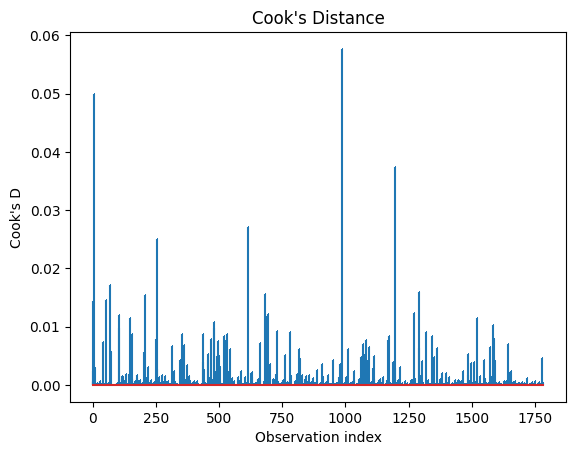

,file_name,file_date,RIC,CAR_ff3_m1_p1
1011,2011-Oct-24-ARWR.OQ-138605471022-Brief.txt,2011-10-24,ARWR.OQ,0.883096
5,2003-Dec-23-KTOS.OQ-138170059987-Brief.txt,2003-12-23,KTOS.OQ,-0.285638
1229,2014-Dec-16-TLM.TO^E15-140114470805-Brief.txt,2014-12-16,TLM.TO^E15,0.319487
632,2009-Apr-01-TRIDQ.PK^L12-138777404660-Brief.txt,2009-04-01,TRIDQ.PK^L12,0.427530
268,2006-Dec-20-RBAK.OQ^B07-140906486755-Brief.txt,2006-12-20,RBAK.OQ^B07,-0.713001
71,2004-May-19-MG.TO-141163042267-Brief.txt,2004-05-19,MG.TO,0.401511
1326,2015-Sep-04-BB.TO-137076106607-Brief.txt,2015-09-04,BB.TO,-0.473837
700,2009-Oct-05-TRIDQ.PK^L12-138733860092-Brief.txt,2009-10-05,TRIDQ.PK^L12,0.427530
217,2005-Oct-31-ABX.TO-137549970932-Brief.txt,2005-10-31,ABX.TO,-0.464389
55,2004-Jun-14-NVLNF.PK^A20-140203857819-Brief.txt,2004-06-14,NVLNF.PK^A20,-0.459838


In [66]:
influence = model.get_influence()
cooks_d = influence.cooks_distance[0]

plt.figure()
plt.stem(cooks_d, markerfmt=",")
plt.title("Cook's Distance")
plt.xlabel("Observation index")
plt.ylabel("Cook's D")
plt.show()

top_idx = np.argsort(cooks_d)[-10:][::-1]
df.loc[mask].iloc[top_idx][["file_name","file_date","RIC","CAR_ff3_m1_p1"]]